In [2]:
%load_ext autoreload
%load_ext rpy2.ipython

%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'png'

from scipy.stats import norm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set_style('darkgrid')

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [4]:
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

In [5]:
from bioreactor.graphs import dense_clustering, gen_graph, draw_graph
from bioreactor.gsea import read_gene_sets, gmt_genes_alt_names, write_gene_sets, read_gmt_as_grouping
from bioreactor.ssgsea import ssgsea, ssgsea_formula
from bioreactor.plotting import clustermap_wp, vector_pie_plot, lin_colors, axis_matras, \
line_palette_annotation_plot, clustering_heatmap, umap_plot, mut_plot, mutation_load_plot, \
draw_cna, axis_net, multi_line_annotation_plot, boxplot_with_pvalue_multi_group, line_annotation_plot
from bioreactor.use_colors import default_cmap, portrait_palette

In [6]:
import os

# Installing required packages

Bioconductor frequently asks to update installed packages, ignore it, typing "n" into promts.

In [7]:
%%R
# Loading required R packages
library(affy) # Loads affymetrix CEL-files
library(gcrma) # Performs array normalization
library(limma) # Used to fit linear models, on which we perform differential expression tests
library(hgu133plus2.db) # This DB stores chip probes to gene symbols conversions
library(annotate) # Used to convert probe id`s to gene symbols

# Lots of warnings is normal, R eagerly reports package loading status

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    IQ

# Loading expressions CEL files

In [10]:
%%R
# Unpack downloaded CEL files with expressions in dir
dir_to_process = './small_cl/GSE10696/'
# Bulk read cell files
raw_expression = ReadAffy(celfile.path = dir_to_process)

%%R -o raw_expression
raw_expression

%%R 
interested_cell_lines_names_s = unlist(interested_cell_lines_names)

%%R
raw_expression@assayData
affyBatch@assayData[which(!(featurenames(raw_expression@assayData) %in% probes.to.remove),]

In [12]:
%%R
# Normalize expression using RMA, it`s a lengthy process, for tests run rma() function,
# Normalize expression using RMA, it`s a lengthy process, for tests run rma() function,
# then performing analysis, use gcrma() function
sample_expressions_normalized = rma(raw_expression)

Background correcting
Normalizing
Calculating Expression


In [13]:
%%R
sample_expressions_normalized

ExpressionSet (storageMode: lockedEnvironment)
assayData: 54675 features, 6 samples 
  element names: exprs 
protocolData
  sampleNames: GSM270524.CEL.gz GSM270525.CEL.gz ... GSM270529.CEL.gz
    (6 total)
  varLabels: ScanDate
  varMetadata: labelDescription
phenoData
  sampleNames: GSM270524.CEL.gz GSM270525.CEL.gz ... GSM270529.CEL.gz
    (6 total)
  varLabels: sample
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation: hgu133plus2 


In [14]:
%%R
sample_expressions_normalized@protocolData@sampleN


Error in withVisible({ : 
  no slot of name "sampleN" for this object of class "AnnotatedDataFrame"


/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in withVisible({ : 
  no slot of name "sampleN" for this object of class "AnnotatedDataFrame"

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: replacing previous import ‘AnnotationDbi::tail’ by ‘utils::tail’ when loading ‘hgu133plus2cdf’ 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: replacing previous import ‘AnnotationDbi::head’ by ‘utils::head’ when loading ‘hgu133plus2cdf’ 

  warnings.warn(x, RRuntimeWarning)


# Creating model matrix

In [132]:
%%R
require(tidyverse)

R[write to console]: Loading required package: tidyverse

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.1.0       ✔ purrr   0.3.0  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.2       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks S4Vectors::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()     masks IRanges::reduce()
✖ dplyr::rename()     masks S4Vectors::rename()
✖ dplyr::select()     masks AnnotationDbi::sel

In [133]:
%%R
ann.filt <- read_tsv("/home/kotlov_group/DATA/1000_cell_lines/Prepared/ic50.cat.tsv", col_names = TRUE)
head(ann.filt)

R[write to console]: Parsed with column specification:
cols(
  Cell_line = col_character(),
  Erlotinib = col_character(),
  `EKB-569` = col_character(),
  Gefitinib = col_character(),
  Cetuximab = col_character(),
  Pos.Response = col_double(),
  Neg.Response = col_double()
)



                Cell_line  Erlotinib        EKB.569  Gefitinib  Cetuximab
1    NCI-H1648_lung_NSCLC Responsive      inbetween Responsive  inbetween
2 BB30-HNC_aero_dig_tract Responsive     Responsive Responsive Responsive
3         EKVX_lung_NSCLC Responsive Not responsive Responsive Responsive
4  LS-513_large_intestine Responsive     Responsive  inbetween  inbetween
5     A253_aero_dig_tract Responsive      inbetween  inbetween  inbetween
6    NCI-H1869_lung_NSCLC Responsive     Responsive  inbetween Responsive
  Pos.Response Neg.Response
1            2            0
2            4            0
3            3            1
4            2            0
5            1            0
6            3            0


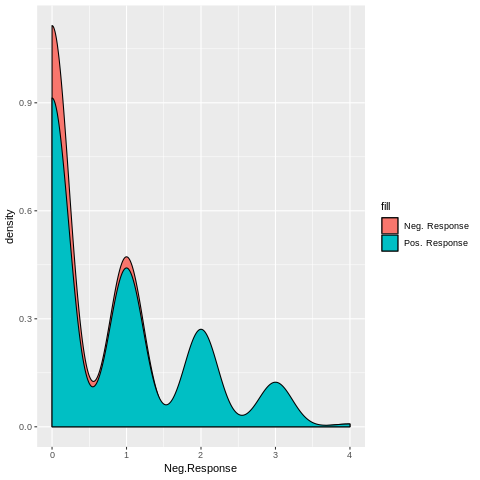

In [134]:
%%R
ggplot() + 
      geom_density(data = ann.filt, aes(x = Neg.Response, fill = "Neg. Response")) + 
      geom_density(data = ann.filt, aes(x = Pos.Response, fill = "Pos. Response"))


In [135]:
%%R
keep <- ann.filt %>% transmute(Cell_line = str_split_fixed(Cell_line, "_", 2)[, 1]) %>% pull(Cell_line)
head(keep)

[1] "NCI-H1648" "BB30-HNC"  "EKVX"      "LS-513"    "A253"      "NCI-H1869"


In [145]:
%%R
sample_expressions_normalized$

ExpressionSet (storageMode: lockedEnvironment)
assayData: 49386 features, 1018 samples 
  element names: exprs 
protocolData
  sampleNames: 5500994157493061613625_A01.cel
    5500994157493061613625_A02.cel ... 5500994175999120813240_H11.cel
    (1018 total)
  varLabels: ScanDate
  varMetadata: labelDescription
phenoData
  sampleNames: 5500994157493061613625_A01.cel
    5500994157493061613625_A02.cel ... 5500994175999120813240_H11.cel
    (1018 total)
  varLabels: sample
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation: hgu219 


In [12]:
annotation['subtype'] = annotation['title'].apply(lambda x: x.split('-')[1])

annotation = annotation['subtype']
annotation.index.name = 'sample_id'

annotation = annotation.reset_index()

NameError: name 'annotation' is not defined

In [81]:
%%R annotation
# Importing annotations from pandas df to R dataframe
summary(annotation)

NameError: name 'annotation' is not defined

In [ ]:
%%R
# Converting DLBCL subtype to factor representation
annotation$subtype = factor(annotation$subtype)

# Setting row names of dataframe, since limma uses rownames to match expressions using it
rownames(annotation) = annotation$sample_id 

# Creating linear models design matrix, this is our features
model_design = model.matrix(~ 0 + subtype, data=annotation)

In [ ]:
%%R
# This is how model design looks, it is simply binary encoding between conditions 
head(model_design)

In [ ]:
%%R
# Creating contrast matrix, which contrast are we interested in?
cont_matrix = makeContrasts('subtypeABC - subtypeUnclassified', 
                            levels=model_design)

In [ ]:
%%R
# This is how contrast matrix looks like, we subtract mean gene levels estemated by model
# between conditions an look for statistically significant differences
cont_matrix

In [ ]:
%%R
# Fitting model with provided features
model_fit = lmFit(sample_expressions_normalized, model_design)

# Subtracting contrasts in fitted model to see difference between classes
contrast_fit = contrasts.fit(model_fit, cont_matrix)

contrast_fit = eBayes(contrast_fit)

In [ ]:
%%R -w 900 -h 900

# Plotting crude volcano plot of results
volcanoplot(contrast_fit, coef=1, 
            highlight=21)

In [ ]:
%%R
# Lets see our chip version
annotation(sample_expressions_normalized)

In [ ]:
%%R -o test_results

# Extracting differentially expressed genes into python for postprocessing
test_results = topTable(contrast_fit, adjust='BH', number=20000, coef=NULL)

# Converting probe id`s to gene symbols
test_results$hugo_symbol = getSYMBOL(rownames(test_results), 'hgu133plus2.db')

test_results$logFC_abs = abs(test_results$logFC)

# Test results will also be converted into pandas dataframe test_results

In [ ]:
test_results.head()

In [ ]:
%%R -w 900 -h 900
library(dplyr)
library(stringr)
library(ggplot2)
library(ggrepel)

# Plotting advanced volcanoplot

# Setting significance thresholds, typcally FDR > 0.1 and fold change > 2 cutoffs are used
fdr_cutoff = 0.1
fc_cutoff = 1.5

test_results$Gene = test_results$hugo_symbol
test_results$threshold = (test_results$adj.P.Val < fdr_cutoff) & (test_results$logFC_abs >= fc_cutoff)

test_results$color = 'non-significant'
test_results$color[test_results$threshold] = 'significant'

test_results$color = factor(test_results$color, 
                            levels=c('non-significant', 
                                     'significant'
                                    ))

set.seed(42)

ggplot(test_results, aes(x = logFC, y=-log10(adj.P.Val), col=color)) + 
    geom_point() + 
    geom_point(data=test_results, aes(col=color), size=3) + 
    geom_text_repel(data=filter(test_results, threshold==TRUE), 
                    aes(label=Gene), 
                    size=7, 
                    force=30, 
                    color='black', 
                    max.iter=6000) +
    scale_color_manual(values=c('gray', '#0de2e2')) + 
    geom_vline(xintercept=c(-1 * fc_cutoff, fc_cutoff), linetype='dotted') +
    geom_vline(xintercept=c(-9, 9), alpha=0) + 
    geom_hline(yintercept=-log10(fdr_cutoff), linetype='dotted') + 
    geom_hline(yintercept=1.5, alpha=0) +
    theme_bw()